In [188]:
%pip install seaborn
%pip install pandas
%pip install scipy
%pip install -U scikit-learn
%pip install pycaret
%pip install xgboost

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as nmp
from scipy import stats
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sb
from pycaret.classification import *
from pycaret.datasets import get_data
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans






Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.0-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-lear

In [189]:
# Import Datasets
launches = pd.read_csv('Launches.csv')
configs = pd.read_csv('Configs.csv')
families = pd.read_csv('Families.csv')
companies = pd.read_csv('Companies.csv')
locations = pd.read_csv('Locations.csv')
missions = pd.read_csv('Missions.csv')

As our dataset is split up between 6 csv files, the dataframe must combine the data from them. For that, we will use joins and, for them to work, the data types must be correctly aligned.

In [190]:
configs['Family Id'] = configs['Family Id'].astype(int)

rockets = pd.merge(configs, families, how = 'inner', on = 'Family Id')

launch_data = pd.merge(launches, locations, how = 'inner', left_on = 'Location', right_on = 'Orig_Addr')
launch_data = pd.merge(launch_data, rockets, how = 'inner', right_on = 'Config', left_on = 'Rocket Name')
launch_data = pd.merge(launch_data, companies, how = 'inner', left_on = 'Rocket Organisation', right_on = 'Company Name')
launch_data = pd.merge(launch_data, missions, how = 'inner', on = 'Launch Id')

Let's now consider the dataset info and all feature present after merging all csvs.

In [191]:
launch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6358 entries, 0 to 6357
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Launch Id                   6358 non-null   int64  
 1   Launch Time                 6358 non-null   object 
 2   Launch Status               6358 non-null   object 
 3   Launch Suborbital           6358 non-null   object 
 4   Rocket Name                 6358 non-null   object 
 5   Rocket Organisation         6358 non-null   object 
 6   Rocket Price                2740 non-null   float64
 7   Rocket Payload to LEO       5773 non-null   float64
 8   Location                    6358 non-null   object 
 9   Launch Year                 6358 non-null   int64  
 10  Launch Year Mon             6358 non-null   object 
 11  USD/kg to LEO               2666 non-null   float64
 12  2021 Mult                   6358 non-null   float64
 13  USD/kg to LEO CPI Adjusted  2666 

In [192]:
launch_data.head()
launch_data.columns

Index(['Launch Id', 'Launch Time', 'Launch Status', 'Launch Suborbital',
       'Rocket Name', 'Rocket Organisation', 'Rocket Price',
       'Rocket Payload to LEO', 'Location', 'Launch Year', 'Launch Year Mon',
       'USD/kg to LEO', '2021 Mult', 'USD/kg to LEO CPI Adjusted',
       'Rocket Price CPI Adjusted', 'Dum', 'Orig_Addr', 'Country',
       'Country_Code', 'Lat', 'Lon', 'Operator', 'Launch Site',
       'Launch Site Lat', 'Launch Site Lon', 'Comb Launch Site',
       'Comb Launch Site Lat', 'Comb Launch Site Lon', 'Operator Lat',
       'Operator Lon', 'Family Id', 'No_x', 'Config', 'Status', 'Price',
       'Liftoff Thrust', 'Payload to LEO', 'Payload to GTO', 'Stages',
       'Strap-ons', 'Rocket Height', 'Fairing Diameter', 'Fairing Height',
       'Family', 'Missions', 'Successes', 'Partial Failures', 'Failures',
       'Success Streak', 'Success Rate', 'Company Name', 'Company Country',
       'Ownership', 'No_y', 'Payloads', 'Mass'],
      dtype='object')

Columns such as the launch id can be ignored, as they are not useful for our analysis. Duplicate rows should also be removed, as well as rows where there is lack of information.

In [193]:
launch_data = launch_data.drop_duplicates()
launch_data = launch_data.dropna()
launch_data = launch_data.drop(["Launch Id"], axis="columns")
launch_data = launch_data.drop(["Family Id"], axis="columns")
launch_data = launch_data.drop(["No_x"], axis="columns")
launch_data = launch_data.drop(["No_y"], axis="columns")
launch_data = launch_data.drop(["Dum"], axis="columns")
launch_data = launch_data.drop(["Launch Year Mon"], axis="columns")
launch_data = launch_data.drop(["Launch Time"], axis="columns")
launch_data = launch_data.drop(["Launch Suborbital"], axis="columns")

converting bad values

In [194]:
launch_data['Price'] = launch_data['Price'].str.replace('$', '').str.replace(' million', '').str.replace(',', '').astype(float)

# Convert thrust to numeric, removing 'kN'
launch_data['Liftoff Thrust'] = launch_data['Liftoff Thrust'].str.replace(' kN', '').str.replace(',', '').astype(float)

# Convert payload capacities to numeric, removing 'kg'
launch_data['Payload to LEO'] = launch_data['Payload to LEO'].str.replace(' kg', '').str.replace(',', '').astype(float)
launch_data['Payload to GTO'] = launch_data['Payload to GTO'].str.replace(' kg', '').str.replace(',', '').astype(float)

# Convert dimensions to numeric, removing 'm'
launch_data['Rocket Height'] = launch_data['Rocket Height'].str.replace(' m', '').astype(float)
launch_data['Fairing Diameter'] = launch_data['Fairing Diameter'].str.replace(' m', '').astype(float)
launch_data['Fairing Height'] = launch_data['Fairing Height'].str.replace(' m', '').astype(float)

# Clean success rate in families
launch_data['Success Rate'] = launch_data['Success Rate'].str.rstrip('%').astype(float) / 100

As the following plot shows, we have a very imbalanced dataset when considering this specific fields.

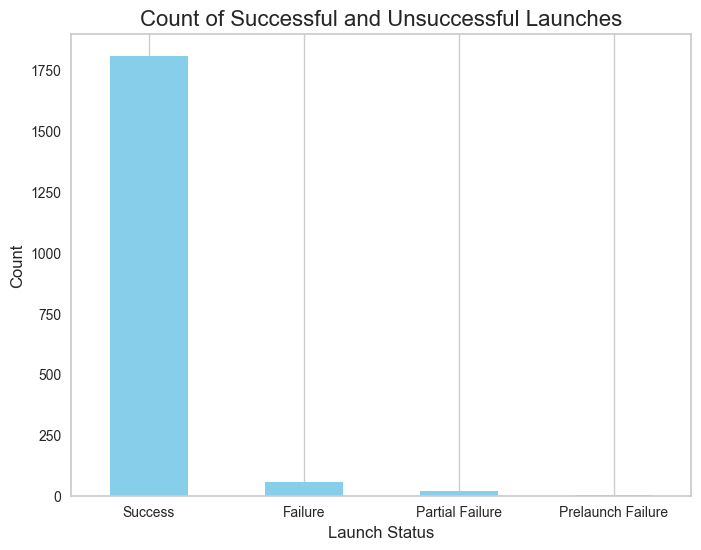

In [195]:
# Count the number of successful and unsuccessful launches
status_counts = launch_data['Launch Status'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [196]:
launch_data['Launch Status'].value_counts()

Launch Status
Success              1810
Failure                56
Partial Failure        20
Prelaunch Failure       1
Name: count, dtype: int64

In order to lower its impact, there are a few approaches that can be taken into consiration. In this instance, we decided to go for under-sampling.

In [197]:

df_majority = launch_data[launch_data['Launch Status'] == 'Success']
df_minority = launch_data[launch_data['Launch Status'] != 'Success']

sample_size = int(len(df_majority)/16)
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=sample_size,     # match number in minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
balanced_status = df_balanced['Launch Status'].value_counts()

Let's run a visualization of the balanced dataset, in order to see what happens when we have a balanced dataset.

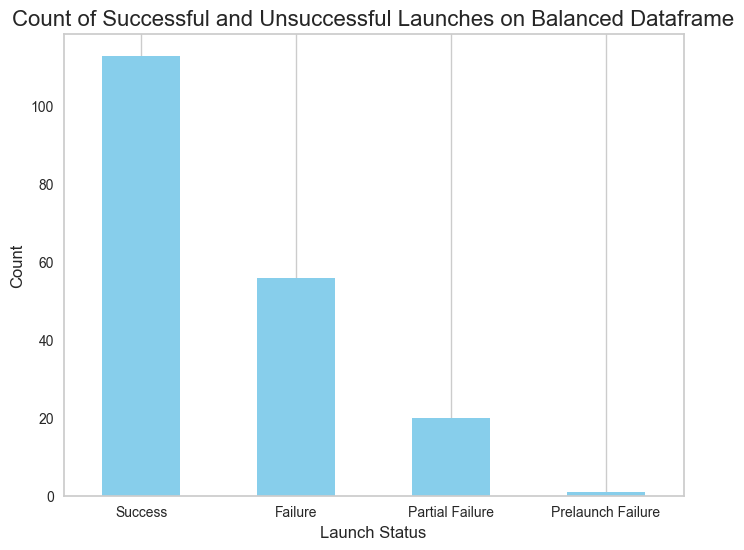

In [198]:
# Plot the histogram
plt.figure(figsize=(8, 6))
balanced_status.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches on Balanced Dataframe', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [199]:
df_balanced['Launch Status'].value_counts()

Launch Status
Success              113
Failure               56
Partial Failure       20
Prelaunch Failure      1
Name: count, dtype: int64

### 1st Question: does the price influence the success of a Launch?

Let's follow an Hypothesis Testing.

Hypothesis
1) Null Hypothesis (Ho): Price has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): Price influences positively the success of a launch. (Is there a correlation?)

Let's first run a boxplot to see the distribution of the data, check if there are any outliers and if their presence is significant.

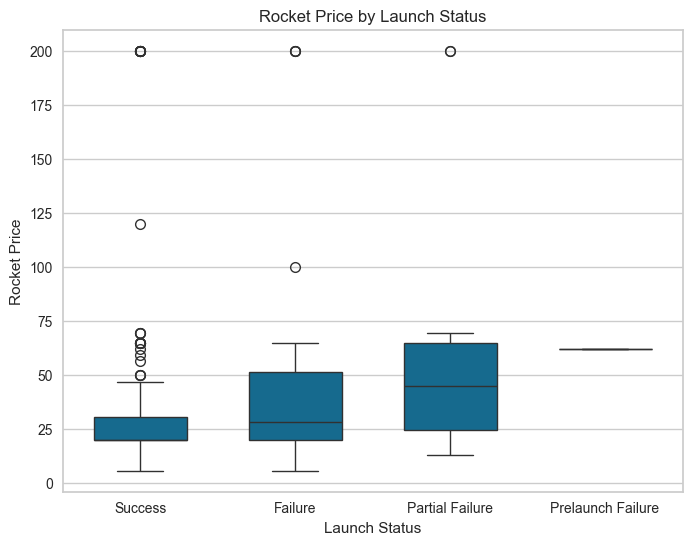

In [200]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Launch Status', y='Rocket Price', data=df_balanced, width=0.6)
plt.title('Rocket Price by Launch Status')
plt.xlabel('Launch Status')
plt.ylabel('Rocket Price')
plt.show()

The boxplot visualization suggests that rocket price is not a decisive factor in determining launch success, as failures happen across all price ranges.

To examine the relationship between rocket price and launch success, we conducted a point-biserial correlation test. This test is appropriate for analyzing the association between a continuous variable (rocket price) and a dichotomous variable (launch success: 0 or 1). You can know more about this specific test in the following link: https://www.statisticshowto.com/point-biserial-correlation/ 

In [201]:
rocket_prices = df_balanced['Rocket Price']
launch_success = (df_balanced['Launch Status'] == 'Success').astype(int)
df_balanced['Launch Success Binary'] = df_balanced['Launch Status'].apply(lambda x: 1 if x.lower() == 'success' else 0)

# Calculate point-biserial correlation
correlation, p_value = stats.pointbiserialr(launch_success, rocket_prices)

print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Correlation coefficient: -0.0478
P-value: 0.5123
Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.


The results show:

- Correlation coefficient: -0.0478
- P-value: 0.5123

With a p-value of 0.5123, which is larger than the conventional significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is no statistically significant relationship between rocket price and launch success.

The correlation coefficient of -0.0478 indicates a very weak negative relationship between price and success. However, given the high p-value, this relationship is not statistically significant and is likely due to random chance rather than a true association in the population.

In conclusion, based on this point-biserial correlation test, we fail to reject the null hypothesis that there is no statistically significant relationship between rocket price and launch success. This suggests that there is no evidence to support the claim that rocket prices are directly related to launch success.

---

### 2nd Question: Is there any corporation more likely to succeed in a launch??

Let's follow a Hypothesis Testing, just as in the first question.

Hypothesis
1) Null Hypothesis (Ho): A rocket's corporation has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): The corporation that fabricated the rocket influences positively the success of a launch. (Is there a correlation?)

We'll start with a simple groupby operation on the Launches data frame. We will group the data by the Rocket Organisation, and then count the number of Total launches for each organization, sum the number of Successful Launches, and provide the average number (Success Rate) of successful launches.

In [202]:
# Group the data by the 'Rocket Organisation' column and calculate the number of launches, successful launches, and success rate.
success_rate = (
    df_balanced.groupby('Rocket Organisation')['Launch Success Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

# Limit the data to only include organizations with at least 5 successful launches, in order to have a more meaningful analysis.
success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate'], ascending=[False])
success_rate.head()

,Total Launches,Successful Launches,Success Rate
Rocket Organisation,,,
Eurockot,7,6,0.857143
CASC,28,22,0.785714
RVSN USSR,59,41,0.694915
SpaceX,9,6,0.666667
Arianespace,16,10,0.625000


Let's run a visualization to understand which is the best contender to be the top rocket organization 🚀

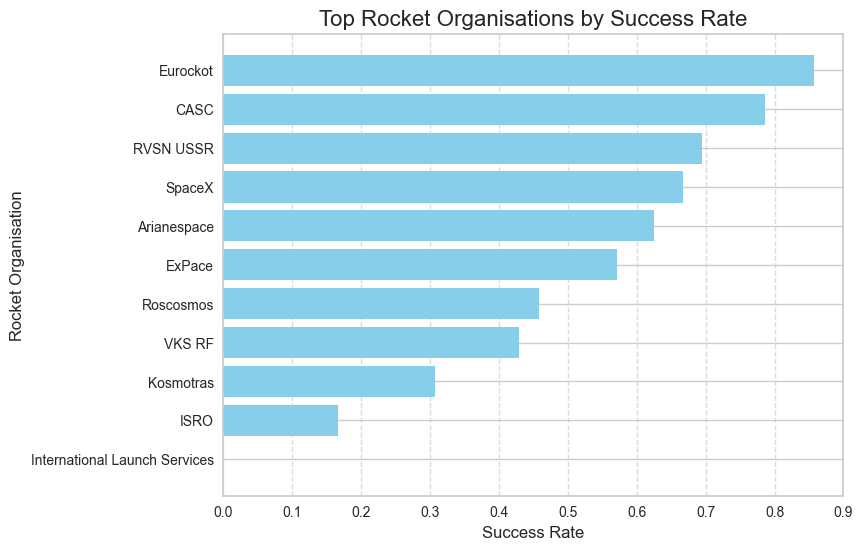

In [203]:
plt.figure(figsize=(8, 6))
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Top Rocket Organisations by Success Rate', fontsize=16)
plt.xlabel('Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The visualisation concludes that **Eurockot** is the most successful Rocket Organisation within this dataset, if we consider only the average of Successful Launches per Rocket Organisation.

Let's dive deeper to understand the data, and see if we can find some relationship between the Rocket's Organization and the launch success.

To examine the relationship between corporation and launch success, we conducted a chi-square independence test (you can get more detailed information on this matter here: https://www.jmp.com/en_be/statistics-knowledge-portal/chi-square-test/chi-square-test-of-independence.html). This test evaluates the independence of a feature (launch success: 0 or 1) from another (corporation). 

In [204]:
# Create a contingency table
contingency_table = pd.crosstab(df_balanced['Rocket Organisation'], df_balanced['Launch Success Binary'])

# Perform the test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}, p-value: {p:.4f}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket organization and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket organization and launch success.")

Chi-square statistic: 30.1258, p-value: 0.0027
Reject the null hypothesis: There is a significant relationship between rocket organization and launch success.


The results show:

- Chi-square statistic: 30.1258,
- P-value: 0.0027

With a p-value of 0.0027, which is exceptionally smaller than the conventional significance level of 0.05, the null hypothesis is rejected, meaning that launch success is, in fact, dependent on the corporation.

The Chi-square statistic of 30.1258 points towards a very strong relationship between corporation and success. Besides that, given the low p-value, we can confirm that this relationship is statistically significant and is likely to be a real association, not being due to chance.

In conclusion, based on this chi-square test and the respective statistical value and P-value, we can conclude that organization has a meaningful influence on launch success.

We can, however, still try to figure out which company is more likely to succeed according to both raw success rate and to residual.

In [205]:
success_rate['Confidence Interval'] = success_rate.apply(
    lambda row: (
        row['Success Rate'] - 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
        row['Success Rate'] + 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
    ),
    axis=1
)

contingency_table = pd.crosstab(df_balanced['Rocket Organisation'], df_balanced['Launch Success Binary'])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate residuals
residuals = (contingency_table - expected) / nmp.sqrt(expected)

# Sort residuals
residuals = residuals.sum(axis=1).sort_values(ascending=False)
print(residuals)

Rocket Organisation
International Launch Services    0.364576
ISRO                             0.287455
Kosmotras                        0.283726
Roscosmos                        0.183193
VKS RF                           0.170445
ExPace                           0.016906
Arianespace                     -0.033186
SpaceX                          -0.059157
Starsem                         -0.111100
ULA                             -0.111100
Eurockot                        -0.190327
RVSN USSR                       -0.210950
CASC                            -0.277038
dtype: float64


Before concluding anything, however, we must reason about the meaning of a high or low, positive or negative residual. The residual looks to highlight, in this case, that a launch's success is more or less likely to be due to randomness and not due to the organization itself. Besides that, we must also understand that confidence intervals are meant to evaluate how consistent the impact of a feature is (in this case, the organization).

After performing the calculation of confidence intervals for each organization, performing a chi-square test and calulating residuals for each enterprise, we understand that:  

- If we are only taking into consideration raw success rate, Eurockot is a clear favorite succeed, as it holds an almost 78% success rate. 
- However, if we are only taking into consideration both the residuals and the confidence intervals and the consistency, International Launch Services comes across as the most consistent organization even while not keeping a higher success-rate - in fact, it was consistently bad! 

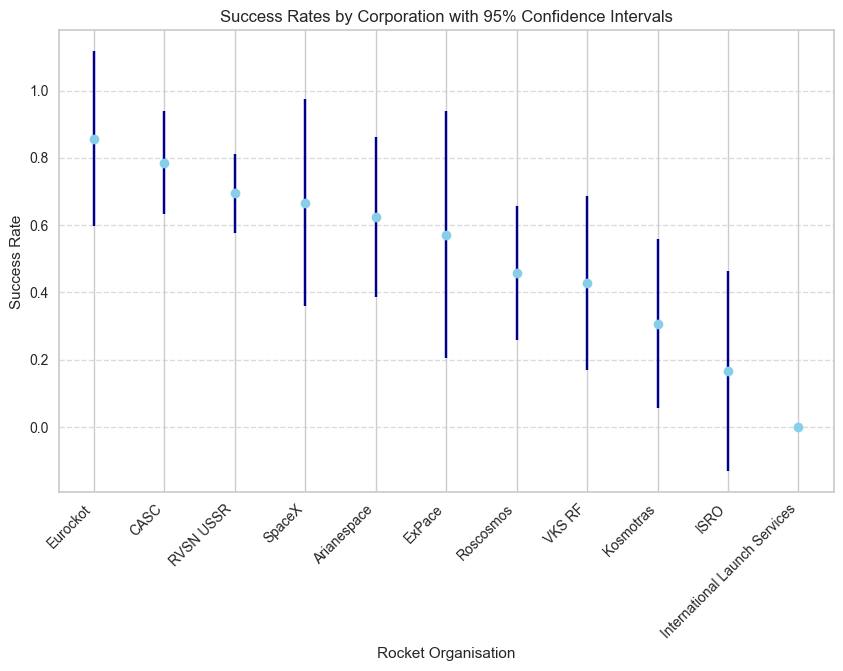

In [206]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    success_rate.index,
    success_rate['Success Rate'],
    yerr=[
        success_rate['Success Rate'] - success_rate['Confidence Interval'].apply(lambda x: x[0]),
        success_rate['Confidence Interval'].apply(lambda x: x[1]) - success_rate['Success Rate']
    ],
    fmt='o', capsize=5, color='skyblue', ecolor='darkblue'
)
plt.title('Success Rates by Corporation with 95% Confidence Intervals')
plt.xlabel('Rocket Organisation')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---

### 3rd Question: Is there any country more likely to succeed in a launch?

Let's follow a Hypothesis Testing, just as in the first question.

Hypothesis
1) Null Hypothesis (Ho): A rocket's base country has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): The country where the rocket is fabricated influences positively the success of a launch.

We'll start with a simple groupby operation on the Launches data frame. We will group the data by Country, and then count the number of Total launches for each country, sum the number of Successful Launches, and provide the average number (Success Rate) of successful launches.

In [207]:
success_rate = (
    df_balanced.groupby('Country')['Launch Success Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate', 'Total Launches'], ascending=[False, False])

success_rate.head()

,Total Launches,Successful Launches,Success Rate
Country,,,
China,35,26,0.742857
United States,10,7,0.700000
Russia,57,37,0.649123
French Guiana,16,10,0.625000
Kazakhstan,66,32,0.484848


Let's run a visualization.

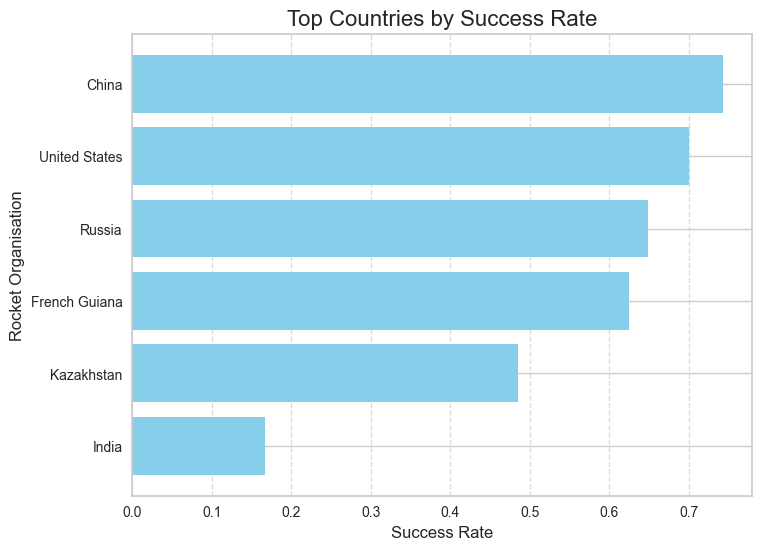

In [208]:
plt.figure(figsize=(8, 6))
# Create an horizontal bar chart
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
# Invert the y-axis
plt.gca().invert_yaxis()
plt.title('Top Countries by Success Rate', fontsize=16)
plt.xlabel('Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
# Add a grid
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The visualisation concludes that China is the most successful Country within this dataset, if we consider only the average of Successful Launches per Country.

Let's dive deeper to understand the data, and see if we can find some relationship between the Rocket's Home Country and the launch success.

In [209]:
# Create a contingency table
contingency_table = pd.crosstab(df_balanced['Country'], df_balanced['Launch Success Binary'])

# Perform the test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}, p-value: {p:.4f}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant relationship between the Country and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between the Country and the launch success.")

Chi-square statistic: 12.2742, p-value: 0.0312
Reject the null hypothesis: There is a significant relationship between the Country and launch success.


To examine the relationship between home country and launch success, we conducted a chi-square independence test (you can get more detailed information on this matter here: https://www.jmp.com/en_be/statistics-knowledge-portal/chi-square-test/chi-square-test-of-independence.html). This test evaluates the independence of a feature (launch success: 0 or 1) from another (country). The results show:

- Chi-square statistic: 12.2742,
- P-value: 0.0312

With a p-value of 0.0312, which is smaller than the conventional significance level of 0.05, the null hypothesis can be rejected, meaning there's a significant relationship between the Launch Country and having a Successful Launch. 

The Chi-square statistic of 12.2742 points towards a stronger relationship between country and success, even if it's not a meaningful relationship. Taking this  p-value into consideration, we can conclude that there is insufficient evidence to conclude that the observed and expected distributions are significantly different or that the variables are dependent.

We can, however, still try to figure out which country is more likely to succeed according to both raw success rate and to residual.

In [210]:
success_rate['Confidence Interval'] = success_rate.apply(
    lambda row: (
        row['Success Rate'] - 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
        row['Success Rate'] + 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
    ),
    axis=1
)

contingency_table = pd.crosstab(df_balanced['Country'], df_balanced['Launch Success Binary'])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate residuals
residuals = (contingency_table - expected) / nmp.sqrt(expected)

# Sort residuals
residuals = residuals.sum(axis=1).sort_values(ascending=False)
print(residuals)

Country
India            0.287455
Kazakhstan       0.244738
French Guiana   -0.033186
United States   -0.091255
Russia          -0.112565
China           -0.240230
dtype: float64


As discussed before, the residual looks to highlight, in this case, that a launch's success is more or less likely to be due to randomness and not due to the country itself. Besides that, we must also remember that confidence intervals are meant to evaluate how consistent the impact of a feature is (in this case, the country).

After performing the calculation of confidence intervals for each country, as well as performing a chi-square test and calulating residuals for each one, we understand that:  

- If we are only taking into consideration raw success rate, China is a clear favorite succeed, as it holds a rounded 83% success rate. 
- However, if we are only taking into consideration both the residuals and the confidence intervals and the consistency, India comes across as the most consistent organization even while not keeping a higher success-rate. 

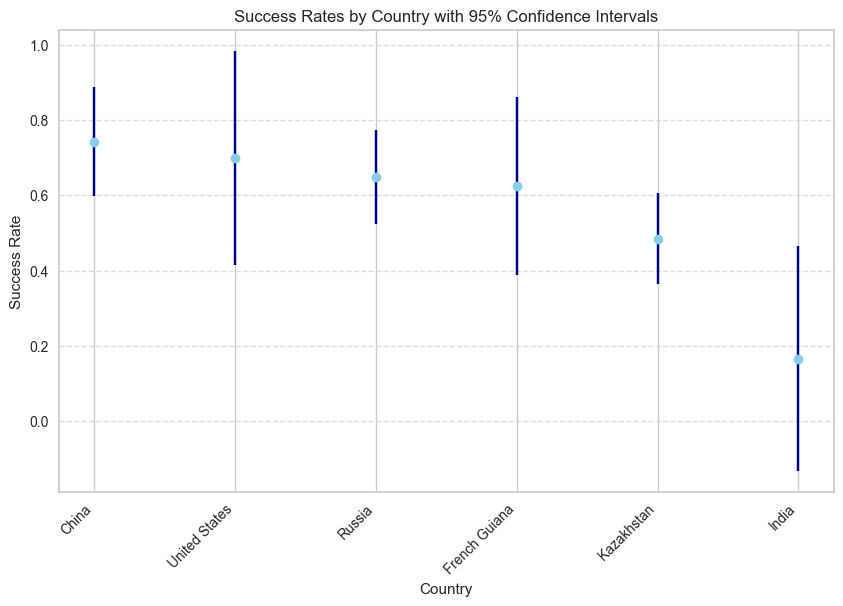

In [211]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    success_rate.index,
    success_rate['Success Rate'],
    yerr=[
        success_rate['Success Rate'] - success_rate['Confidence Interval'].apply(lambda x: x[0]),
        success_rate['Confidence Interval'].apply(lambda x: x[1]) - success_rate['Success Rate']
    ],
    fmt='o', capsize=5, color='skyblue', ecolor='darkblue'
)
plt.title('Success Rates by Country with 95% Confidence Intervals')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Data Modeling

As part of the Data Science process, we need to model the data in order to make realistic predictions. In this sense, we need, first, to arrange the data so it cane be used in a machine learning model. 

In [212]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Launch Status               190 non-null    object 
 1   Rocket Name                 190 non-null    object 
 2   Rocket Organisation         190 non-null    object 
 3   Rocket Price                190 non-null    float64
 4   Rocket Payload to LEO       190 non-null    float64
 5   Location                    190 non-null    object 
 6   Launch Year                 190 non-null    int64  
 7   USD/kg to LEO               190 non-null    float64
 8   2021 Mult                   190 non-null    float64
 9   USD/kg to LEO CPI Adjusted  190 non-null    float64
 10  Rocket Price CPI Adjusted   190 non-null    float64
 11  Orig_Addr                   190 non-null    object 
 12  Country                     190 non-null    object 
 13  Country_Code                190 non

For the data to be used in a machine learning model, we need to have the categorical variables in a numerical format. This is done by one-hot encoding. The one-hot encoding is a technique that converts categorical data into a numerical format. It is used to convert categorical data into a format that can be used by machine learning algorithms.


In [213]:
# Encode categorical variables
categorical_columns = [
    'Country', 'Country_Code', 'Operator', 'Launch Site',
    'Comb Launch Site', 'Company Country', 'Ownership', 'Config',
    'Status', 'Rocket Name', 'Rocket Organisation', 'Location', 'Launch Status', 'Orig_Addr', 'Family', 'Company Name'
]

encoded_categorical_columns = []
for column in categorical_columns:
    encoded_categorical_columns.append(column+'_encoded')
    
label_encoders = {}
for col in categorical_columns:
    if col in df_balanced.columns:
        label_encoders = LabelEncoder()
        df_balanced[col] = label_encoders.fit_transform(df_balanced[col])

df_balanced.drop(categorical_columns, axis=1)


,Rocket Price,Rocket Payload to LEO,Launch Year,USD/kg to LEO,2021 Mult,USD/kg to LEO CPI Adjusted,Rocket Price CPI Adjusted,Lat,Lon,Launch Site Lat,...,Fairing Height,Missions,Successes,Partial Failures,Failures,Success Streak,Success Rate,Payloads,Mass,Launch Success Binary
0,20.00,6860.0,1978,29154.518950,4.155982,121165.644172,83.119632,62.927855,40.574841,62.926415,...,15.590,859.0,835.0,2.0,22.0,1.0,0.973,1.0,6300.0,1
1,20.00,6860.0,1986,29154.518950,2.472354,72080.291971,49.447080,62.927855,40.574841,62.926415,...,15.590,859.0,835.0,2.0,22.0,1.0,0.973,1.0,6300.0,1
2,20.00,6860.0,1984,29154.518950,2.607988,76034.648701,52.159769,62.927855,40.574841,62.926415,...,15.590,859.0,835.0,2.0,22.0,1.0,0.973,1.0,6300.0,1
3,25.00,3250.0,1993,76923.076923,1.875225,144248.070269,46.880623,13.733526,80.234720,13.728419,...,8.300,53.0,50.0,1.0,2.0,12.0,0.953,1.0,846.0,0
4,200.00,21000.0,2015,95238.095238,1.143251,108881.078854,228.650266,5.240305,-52.768414,5.201590,...,17.000,112.0,107.0,3.0,2.0,15.0,0.969,1.0,4364.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,20.00,6860.0,1980,29154.518950,3.288471,95873.786408,65.769417,45.964585,63.305243,45.964585,...,15.590,859.0,835.0,2.0,22.0,1.0,0.973,1.0,6300.0,1
186,29.15,11500.0,2020,25347.826087,1.046980,26538.672757,30.519474,27.893082,102.244872,27.893551,...,9.560,141.0,133.0,6.0,2.0,17.0,0.965,1.0,5550.0,0
187,19.00,1080.0,2020,175925.925926,1.046980,184190.966181,19.892624,38.848577,111.607983,38.848577,...,6.145,8.0,8.0,0.0,0.0,8.0,1.000,1.0,8.0,1
188,20.00,6860.0,1976,29154.518950,4.762214,138840.070299,95.244288,62.919937,40.467031,62.926415,...,15.590,859.0,835.0,2.0,22.0,1.0,0.973,1.0,6300.0,1


In [214]:
display(df_balanced)

,Launch Status,Rocket Name,Rocket Organisation,Rocket Price,Rocket Payload to LEO,Location,Launch Year,USD/kg to LEO,2021 Mult,USD/kg to LEO CPI Adjusted,...,Partial Failures,Failures,Success Streak,Success Rate,Company Name,Company Country,Ownership,Payloads,Mass,Launch Success Binary
0,3,32,7,20.00,6860.0,23,1978,29154.518950,4.155982,121165.644172,...,2.0,22.0,1.0,0.973,7,4,1,1.0,6300.0,1
1,3,32,7,20.00,6860.0,17,1986,29154.518950,2.472354,72080.291971,...,2.0,22.0,1.0,0.973,7,4,1,1.0,6300.0,1
2,3,32,7,20.00,6860.0,17,1984,29154.518950,2.607988,76034.648701,...,2.0,22.0,1.0,0.973,7,4,1,1.0,6300.0,1
3,0,21,4,25.00,3250.0,2,1993,76923.076923,1.875225,144248.070269,...,1.0,2.0,12.0,0.953,4,2,1,1.0,846.0,0
4,3,1,0,200.00,21000.0,0,2015,95238.095238,1.143251,108881.078854,...,3.0,2.0,15.0,0.969,0,3,0,1.0,4364.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,3,32,7,20.00,6860.0,13,1980,29154.518950,3.288471,95873.786408,...,2.0,22.0,1.0,0.973,7,4,1,1.0,6300.0,1
186,0,15,1,29.15,11500.0,4,2020,25347.826087,1.046980,26538.672757,...,6.0,2.0,17.0,0.965,1,0,1,1.0,5550.0,0
187,3,20,1,19.00,1080.0,3,2020,175925.925926,1.046980,184190.966181,...,0.0,0.0,8.0,1.000,1,0,1,1.0,8.0,1
188,3,32,7,20.00,6860.0,24,1976,29154.518950,4.762214,138840.070299,...,2.0,22.0,1.0,0.973,7,4,1,1.0,6300.0,1


Before running the models, we will first check the correlations between the variables. For this, we will run the point biserial correlation function from the scipy.stats library.

In [215]:
 # Select numeric features
numeric_cols = df_balanced.select_dtypes(include=['int64', 'int32', 'float64']).columns
numeric_features = [col for col in numeric_cols if col != 'Launch Success Binary']

# Calculate point biserial correlation
correlations = {}
for col in numeric_features:
    corr, _ = pointbiserialr(df_balanced[col], df_balanced['Launch Success Binary'])
    correlations[col] = corr

correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])

display(correlations_df)

,Correlation
Launch Status,0.974738
Rocket Name,0.096772
Rocket Organisation,-0.116981
Rocket Price,-0.047827
Rocket Payload to LEO,-0.156458
Location,-0.043748
Launch Year,-0.103089
USD/kg to LEO,0.045418
2021 Mult,0.125639
USD/kg to LEO CPI Adjusted,0.123886


As a visualization tool, we will plot an heatmap.

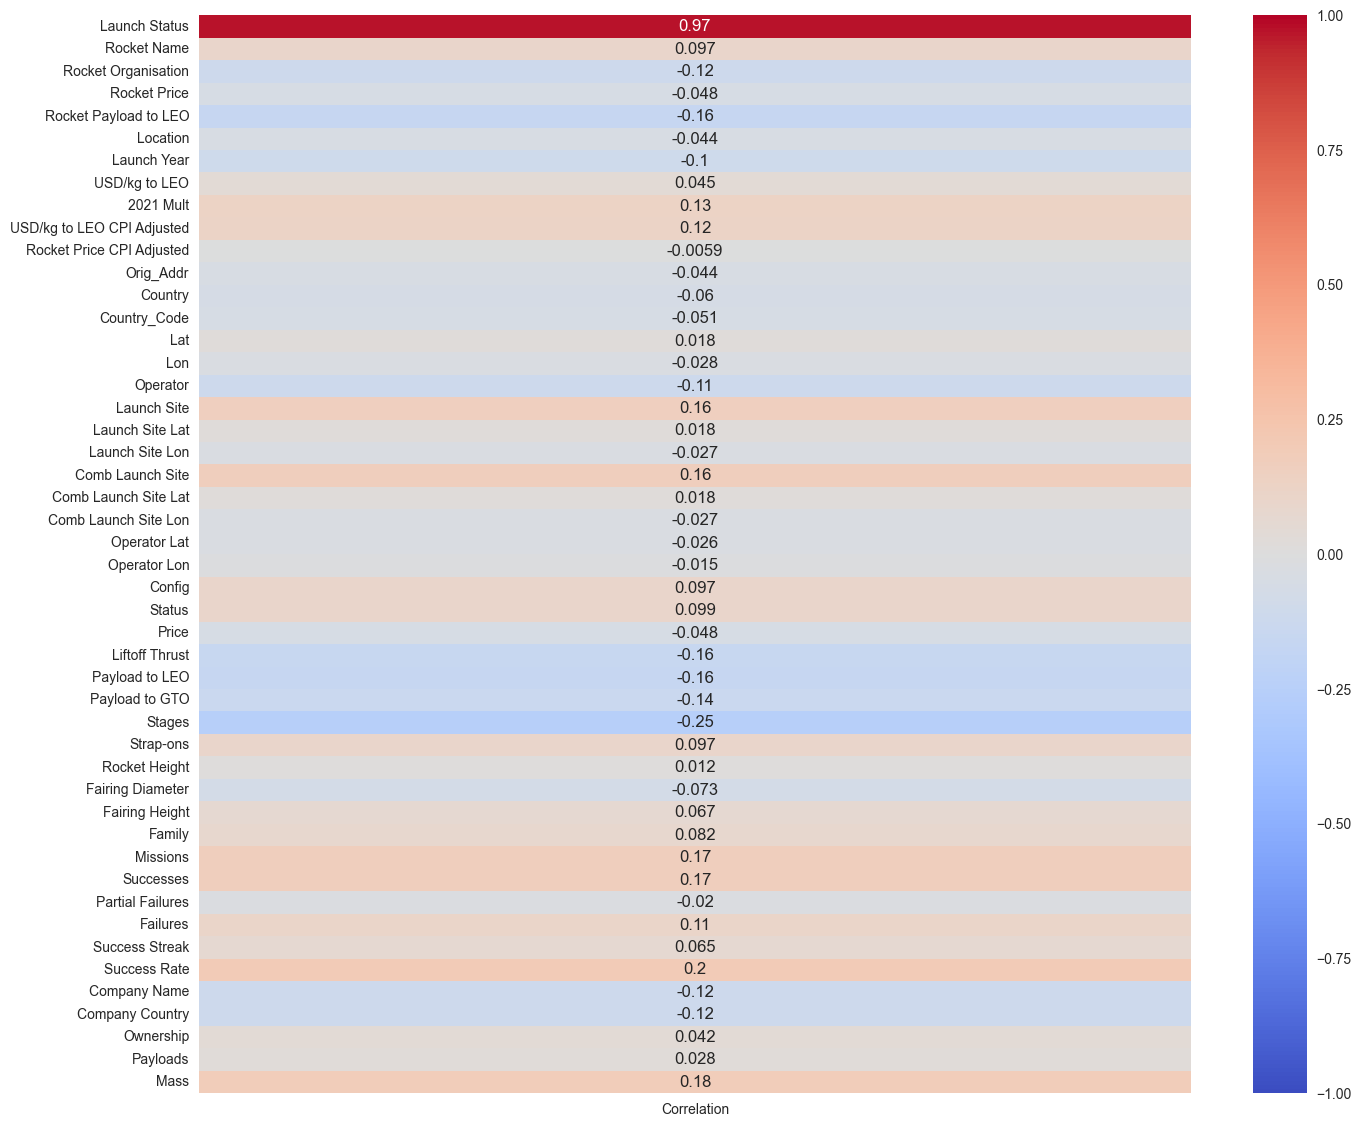

In [216]:
#sorted_corr = correlations.sort_values(by='Launch Success Binary', ascending=False)

# Set the figure size to ensure all values fit
plt.figure(figsize=(16, 14))  # Adjust the size as needed

# Plot the heatmap
sb.heatmap(correlations_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()


As the correlation between the features 'Launch Status' and 'Launch Success Binary' is extremely high, we will ignore the first, as it may be missleading. Both variables represent the same type of information.

In [217]:
df_balanced = df_balanced.drop('Launch Status', axis=1)

In [218]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rocket Name                 190 non-null    int64  
 1   Rocket Organisation         190 non-null    int64  
 2   Rocket Price                190 non-null    float64
 3   Rocket Payload to LEO       190 non-null    float64
 4   Location                    190 non-null    int64  
 5   Launch Year                 190 non-null    int64  
 6   USD/kg to LEO               190 non-null    float64
 7   2021 Mult                   190 non-null    float64
 8   USD/kg to LEO CPI Adjusted  190 non-null    float64
 9   Rocket Price CPI Adjusted   190 non-null    float64
 10  Orig_Addr                   190 non-null    int64  
 11  Country                     190 non-null    int64  
 12  Country_Code                190 non-null    int64  
 13  Lat                         190 non

For the modelling, we need to define the features and the target variable. The features are the variables that we want to predict, and the target variable is the variable that we want to predict. In this case, we will use all the variables in the dataset, except the Launch Success Binary variable, which is the target variable.

Then, we must split the dataset into training and testing sets. The training set will be used to train the model, and the testing set will be used to evaluate the performance of the model. In this case, we will use 80% of the data for training and 20% for testing. This technique is called a train-test split. You can know more about it [here](https://builtin.com/data-science/train-test-split).

In [219]:
features = df_balanced.drop(['Launch Success Binary'], axis=1)
target = df_balanced['Launch Success Binary']

nmp.unique(target, return_counts=True)

(array([0, 1]), array([ 77, 113]))

In [220]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.2, random_state=42)
nmp.unique(y_train, return_counts=True), nmp.unique(y_test, return_counts=True)

((array([0, 1]), array([60, 92])), (array([0, 1]), array([17, 21])))

In [221]:
model_comparison = pd.DataFrame(columns=['Model', 'Accuracy'])

We will run the following Machine Learning Models: 
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier
- Support Vector Machine

All these models are classified as Supervised Learning Models and Classification Models, since we are trying to predict the success or not of a rocket launch.

### Logistic Regression
A linear model used for binary classification that estimates the probability of a class using a logistic function. It assumes a linear relationship between features and the log-odds of the target variable.

In [222]:
model = LogisticRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

lr_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy*100:.2f}%")

row = pd.DataFrame({'Model' : ['Logistic Regression'], 'Accuracy' : [round(lr_accuracy*100,2)]})
model_comparison = pd.concat([model_comparison ,row], ignore_index=True)

Logistic Regression Accuracy: 60.53%


We will always run a confusion matrix to see how well our model is doing. This is a good way to check if our model is overfitting or underfitting. Overfitting is when the model is too complex and learns to predict the training data. Underfitting is when the model is too simple and doesn't learn enough to predict the training data. The diagonal of the confusion matrix is the number of correct predictions. The off-diagonals are the number of incorrect predictions.

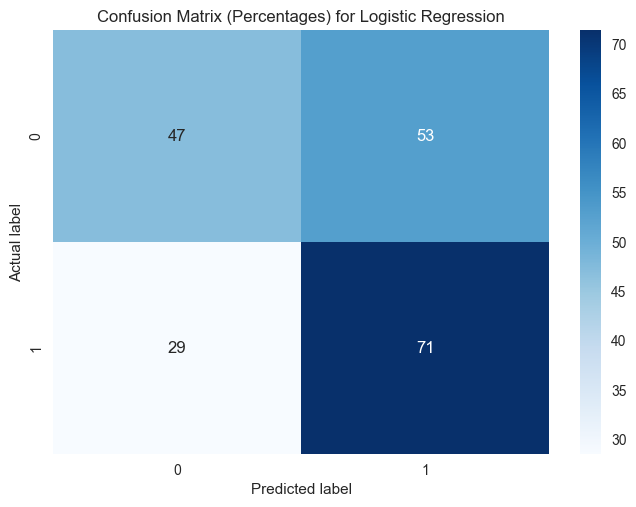

In [223]:
cm_lr = confusion_matrix(y_test, y_pred)
cm_percentages = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, nmp.newaxis] * 100

# Create heatmap with percentages
categories = nmp.unique(df_balanced[['Launch Success Binary']])
sns.heatmap(cm_percentages, annot=True, fmt='.0f', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (Percentages) for Logistic Regression')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Decision Tree Classifier
A non-linear model that splits data into regions based on feature thresholds. It’s interpretable but prone to overfitting without regularization.

In [224]:
model = DecisionTreeClassifier(max_depth = 3)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

dtc_accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Classifier Accuracy: {dtc_accuracy*100:.2f}%")

row = pd.DataFrame({'Model' : ['Decision Tree Classifier'], 'Accuracy' : [round(dtc_accuracy*100,2)]})
model_comparison = pd.concat([model_comparison ,row], ignore_index=True)

Decision Tree Classifier Accuracy: 60.53%


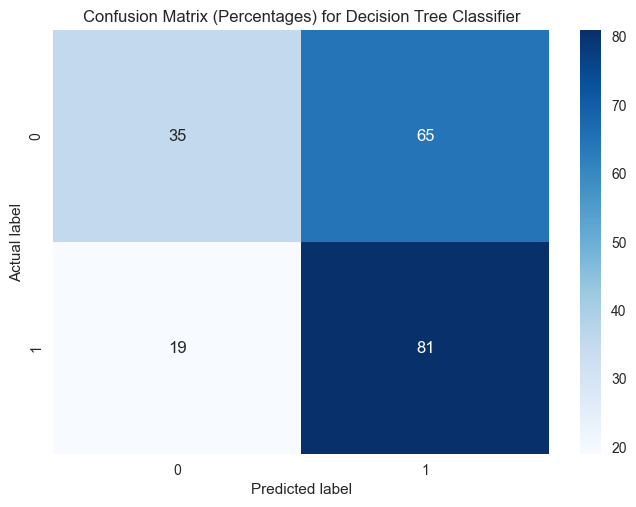

In [225]:
cm_dtc = confusion_matrix(y_test, y_pred)
cm_percentages = cm_dtc.astype('float') / cm_dtc.sum(axis=1)[:, nmp.newaxis] * 100

# Create heatmap with percentages
categories = nmp.unique(df_balanced[['Launch Success Binary']])

sns.heatmap(cm_percentages, annot=True, fmt='.0f', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (Percentages) for Decision Tree Classifier')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Random Forest Classifier
An ensemble method that builds multiple decision trees and combines their predictions to improve performance and reduce overfitting.

In [226]:
model = RandomForestClassifier(n_estimators=1000, random_state=0)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {rf_accuracy*100:.2f}%")

row = pd.DataFrame({'Model' : ['Random Forest Classifier'], 'Accuracy' : [round(rf_accuracy*100,2)]})
model_comparison = pd.concat([model_comparison ,row], ignore_index=True)

Random Forest Classifier Accuracy: 68.42%


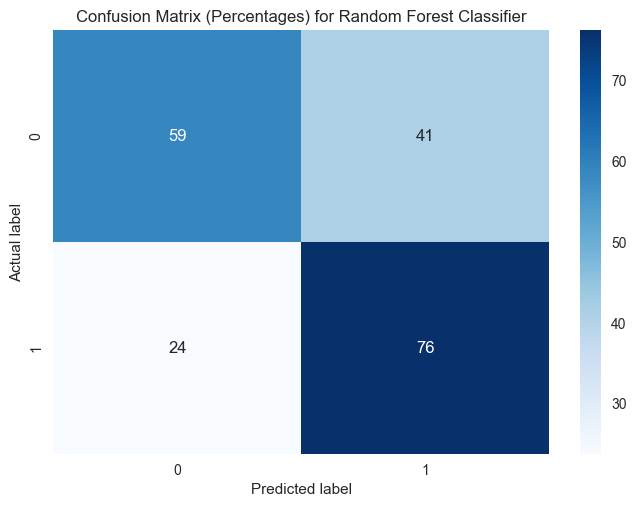

In [227]:
cm_rf = confusion_matrix(y_test, y_pred)

cm_percentages = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, nmp.newaxis] * 100

categories = nmp.unique( df_balanced[['Launch Success Binary']])
sns.heatmap(cm_percentages, annot=True, fmt='.0f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (Percentages) for Random Forest Classifier')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### XGBoost
A gradient-boosting algorithm optimized for speed and performance, particularly effective in handling non-linear relationships and feature importance.

In [228]:
model = xgb.XGBClassifier(random_state=42)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

xgb_accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {xgb_accuracy*100:.2f}%")

row = pd.DataFrame({'Model' : ['XGBoost'], 'Accuracy' : [round(xgb_accuracy*100,2)]})
model_comparison = pd.concat([model_comparison ,row], ignore_index=True)


XGBoost Accuracy: 65.79%


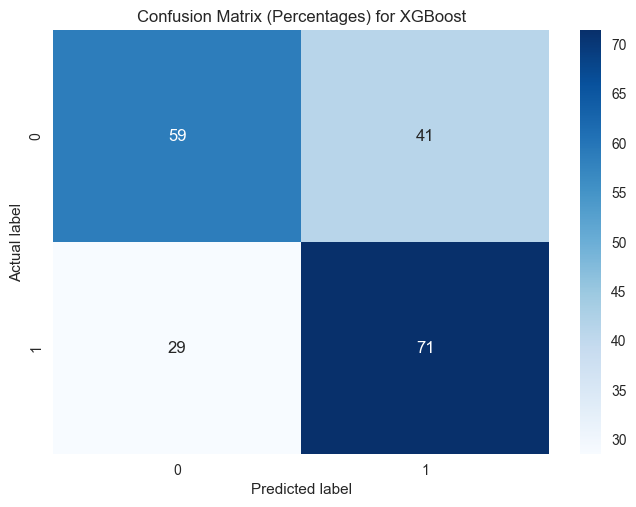

In [229]:
cm_xgb = confusion_matrix(y_test, y_pred)

cm_percentages = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, nmp.newaxis] * 100

categories = nmp.unique( df_balanced[['Launch Success Binary']])
sns.heatmap(cm_percentages, annot=True, fmt='.0f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (Percentages) for XGBoost')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### SVM (Support Vector Machine)
A model that finds the optimal hyperplane to separate classes. It works well with high-dimensional data but may struggle with large datasets or noise.

In [230]:
model = SVC(random_state=42)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Support Vector Machine Accuracy: {svm_accuracy*100:.2f}%")

row = pd.DataFrame({'Model' : ['Support Vector Machine'], 'Accuracy' : [round(svm_accuracy*100,2)]})
model_comparison = pd.concat([model_comparison ,row], ignore_index=True)


Support Vector Machine Accuracy: 55.26%


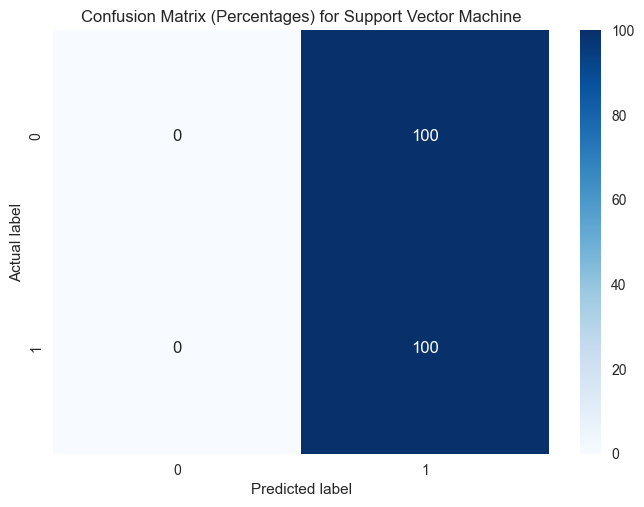

In [231]:
cm_svm = confusion_matrix(y_test, y_pred)

cm_percentages = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, nmp.newaxis] * 100

categories = nmp.unique( df_balanced[['Launch Success Binary']])

sns.heatmap(cm_percentages, annot=True, fmt='.0f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (Percentages) for Support Vector Machine')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### KNN (K-Neighbors)
A simple instance-based learning algorithm that classifies data based on the majority class of its nearest neighbors. It’s sensitive to feature scaling and data density.

In [232]:
model = KNeighborsClassifier()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

knn_accuracy = accuracy_score(y_test, y_pred)
print(f"K-Neighbors Accuracy: {knn_accuracy*100:.2f}%")

row = pd.DataFrame({'Model' : ['K-Neighbors'], 'Accuracy' : [round(knn_accuracy*100,2)]})
model_comparison = pd.concat([model_comparison ,row], ignore_index=True)


K-Neighbors Accuracy: 63.16%


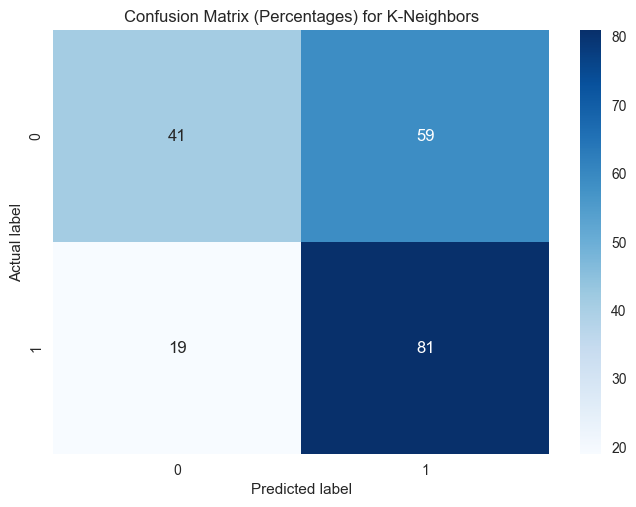

In [233]:
cm_knn = confusion_matrix(y_test, y_pred)

cm_percentages = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, nmp.newaxis] * 100

categories = nmp.unique( df_balanced[['Launch Success Binary']])

sns.heatmap(cm_percentages, annot=True, fmt='.0f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (Percentages) for K-Neighbors')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [234]:
model_comparison.head()

,Model,Accuracy
0,Logistic Regression,60.53
1,Decision Tree Classifier,60.53
2,Random Forest Classifier,68.42
3,XGBoost,65.79
4,Support Vector Machine,55.26


The Random Forest Classifier achieved the highest accuracy at 68.42%, followed by XGBoost at 65.79%, while other models like Logistic Regression, Decision Tree, and K-Nearest Neighbors were at 60.53%. SVM was the least accurate at 55.26%. The dataset's imbalance, even after undersampling, likely contributes to these moderate accuracy levels, as the models might struggle to capture minority class patterns effectively. This imbalance may have caused biases in prediction, favoring the majority class and limiting overall model performance. Exploring alternative resampling techniques, class weighting, or more targeted feature engineering could help address these issues.